## Описание проекта

Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года:
лог сервера с данными о посещениях сайта Яндекс.Афиши,
выгрузка всех заказов за этот период,
статистика рекламных расходов.

Предстоит изучить:
* как клиенты пользуются сервисом
* когда делают первые покупки на сайте
* сколько денег приносит компании каждый клиент
* когда расходы на привлечение клиента окупаются.

## Разобьём проект на части:

* [Выгрузка данных](#id-section1)
* [Расчёт метрик и построение графиков](#id-section2)
  * [Продктовые метрики](#id-section3)
  * [Метрики электронной коммерции](#id-section4)
  * [Маркетинговые метрики](#id-section5)
* [Выводы и рекомендации](#id-section6)

In [102]:
import pandas as pd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt
import seaborn as sns

<div id='id-section1'/>

## Шаг1. Выгрузим данные

In [103]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

In [104]:
# Код ревьюера для расчета среднего чека 
orders_start_df = orders.copy()

In [105]:
display(visits.info())
display(orders.info())
display(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

In [106]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']

Преобразуем все даты в формат datetime

In [107]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

<div id='id-section2'/>

## Шаг2. Расчёт метрик и построение графиков

<div id='id-section3'/>

#### DAU,  MAU,  WAU

Найдём DAU, MAU и WAU. Для этого воспользуемся данными таблицы vists. Добавим столбец с годом, месяцем и днём заказа.

In [108]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

In [109]:
visits['device'].value_counts()
visits[visits['device']=='touch'].groupby('session_date').agg({'uid':'nunique'})

,uid
session_date,
2017-06-01,153
2017-06-02,152
2017-06-03,139
2017-06-04,153
2017-06-05,195
...,...
2018-05-27,236
2018-05-28,303
2018-05-29,263


In [110]:
def au(data, device):
    data = data[data['device']==device]
    dau = data.groupby('session_date').agg({'uid':'nunique'})
    wau = data.groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
    mau = data.groupby(['session_year', 'session_month']).agg({'uid':'nunique'})
    ax=dau['uid'].plot(kind='line', figsize=(16, 5), title='DAU '+device, grid=True)
    ax.set_ylabel('dau')
    plt.show()
    ax=wau['uid'].plot(kind='line', figsize=(16, 5), title='WAU '+device, grid=True)
    ax.set_ylabel('wau')
    plt.show()
    ax=mau['uid'].plot(kind='bar', figsize=(16, 5), title='MAU '+device, grid=True)
    ax.set_ylabel('mau')

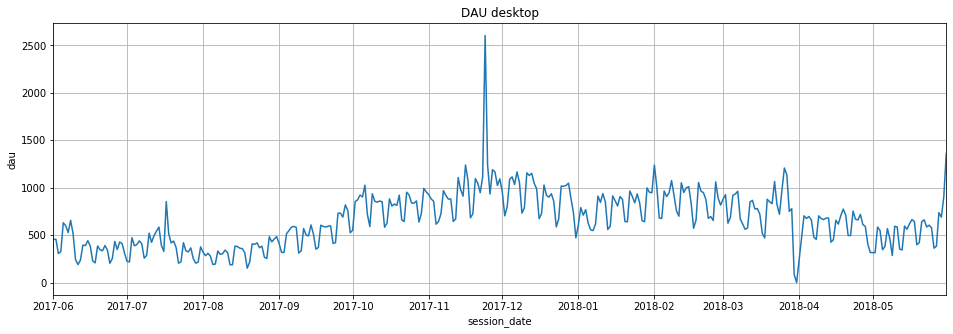

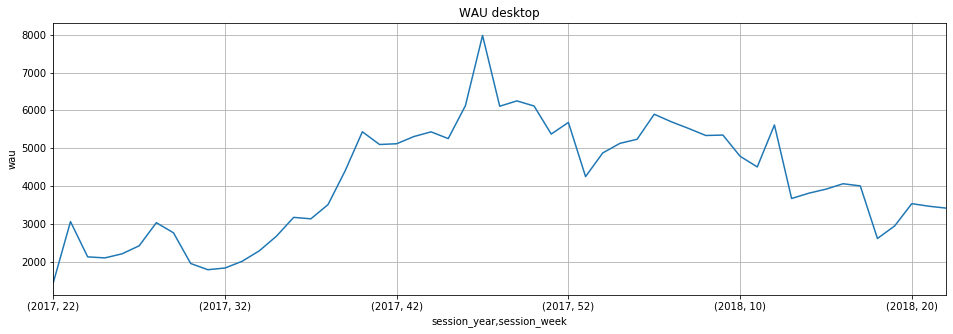

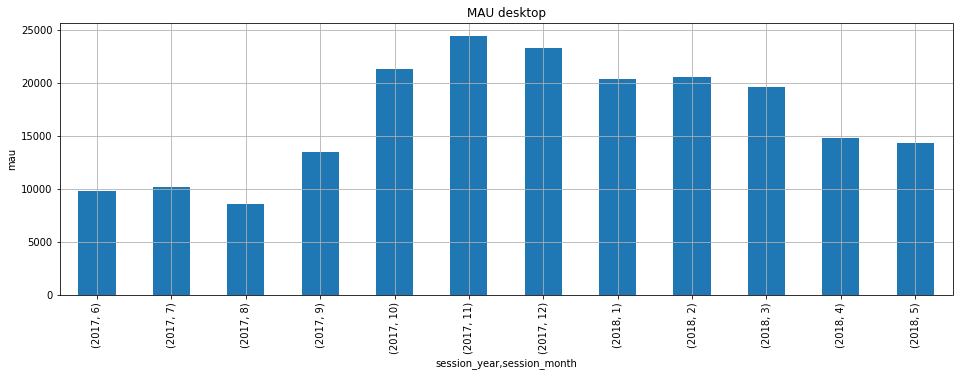

In [111]:
au(visits, 'desktop')

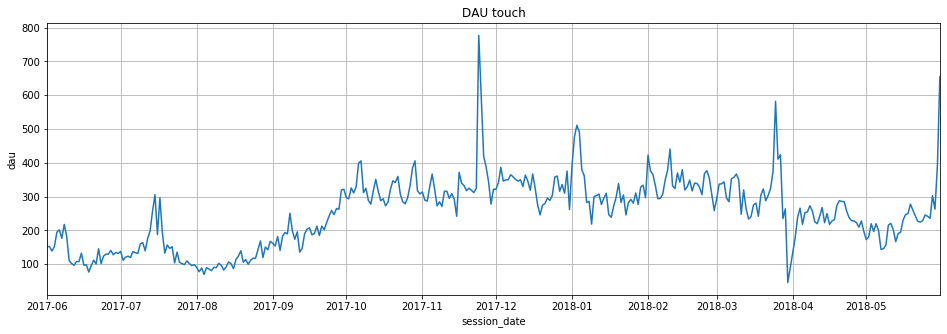

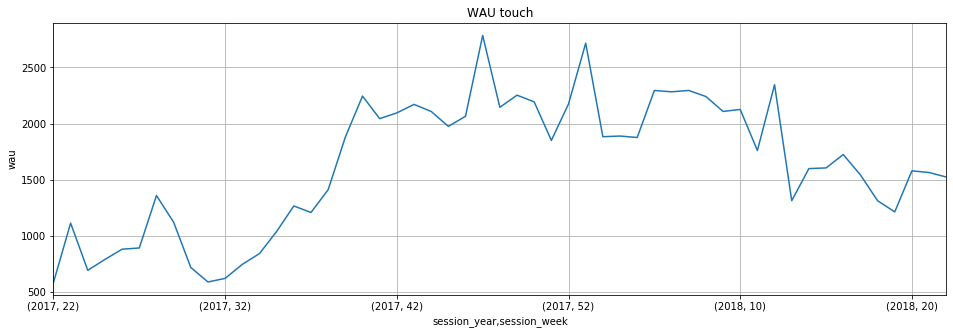

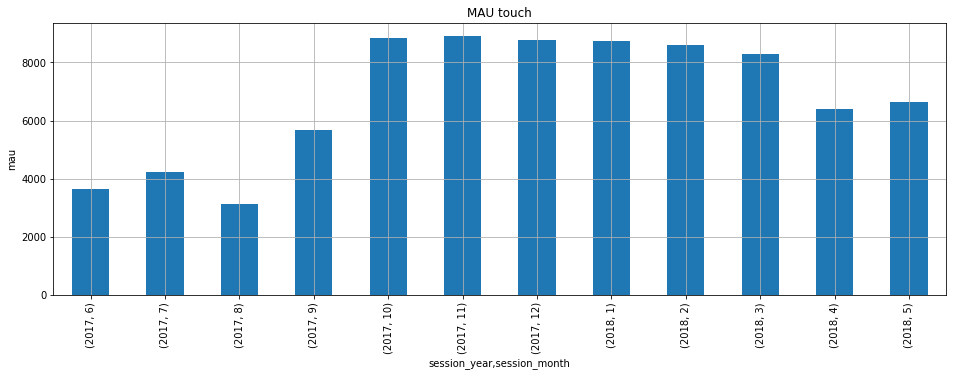

In [112]:
au(visits, 'touch')

In [113]:
dau = visits[visits['device']=='desktop'].groupby('session_date').agg({'uid':'nunique'})
wau = visits[visits['device']=='desktop'].groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
mau = visits[visits['device']=='desktop'].groupby(['session_year', 'session_month']).agg({'uid':'nunique'})

print('DAU desktop: {}'.format(dau['uid'].mean()))
print('WAU desktop: {}'.format(wau['uid'].mean()))
print('MAU desktop: {}'.format(mau['uid'].mean()))

DAU desktop: 659.2445054945055
WAU desktop: 4129.509433962264
MAU desktop: 16724.916666666668


In [114]:
dau = visits[visits['device']=='touch'].groupby('session_date').agg({'uid':'nunique'})
wau = visits[visits['device']=='touch'].groupby(['session_year', 'session_week']).agg({'uid':'nunique'})
mau = visits[visits['device']=='touch'].groupby(['session_year', 'session_month']).agg({'uid':'nunique'})

print('DAU touch: {}'.format(dau['uid'].mean()))
print('WAU touch: {}'.format(wau['uid'].mean()))
print('MAU touch: {}'.format(mau['uid'].mean()))

DAU touch: 252.8732782369146
WAU touch: 1634.9245283018868
MAU touch: 6825.916666666667


### Вывод:

Отметим резкое подаение посещаемости во втором квартале 2018 году. Снижаются такие метрики как DAU, WAU и MAU. В целом пользователей с desktop больше чем с touch, однаком поведение графиков схоже.

#### Определим, сколько раз в день в среднем заходят пользователи.

In [115]:
def user_visit(data, device):
    data = data[data['device']==device]
    user_visits = data.groupby('session_date').agg({'uid':['count', 'nunique']}).reset_index()
    user_visits.columns = ['session_date', 'uid_count', 'uid_unique']
    user_visits = user_visits.set_index(['session_date'])
    user_visits['session_per_day'] = user_visits['uid_count'] / user_visits['uid_unique']
    ax=user_visits['session_per_day'].plot(kind='line', grid=True, figsize=(16, 5), title='Посещений на пользователя в день для '+device)
    ax.set_ylabel('count')
    plt.show()

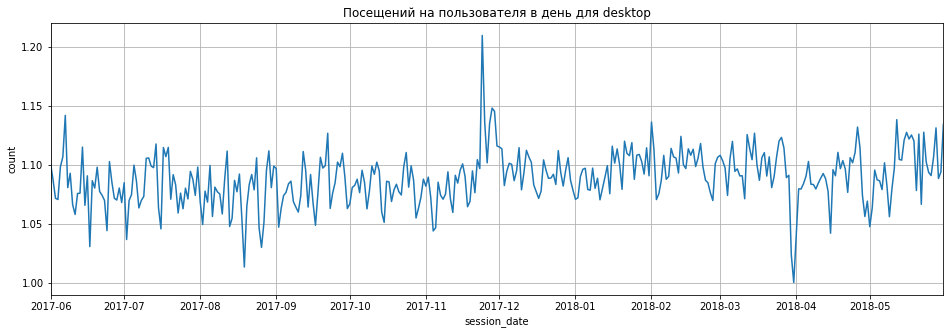

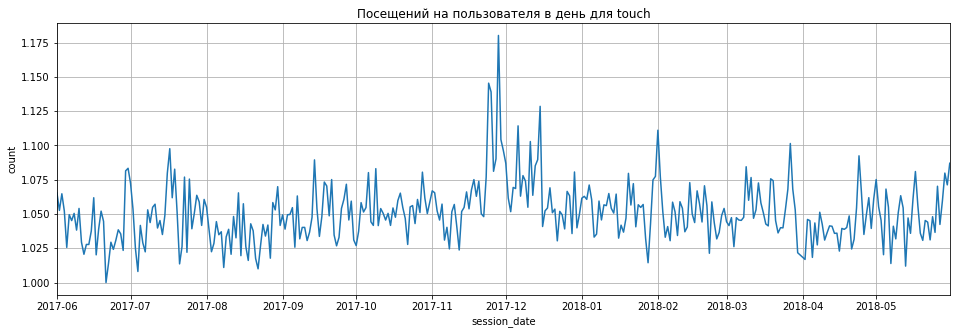

In [116]:
user_visit(visits, 'desktop')
user_visit(visits, 'touch')

### Вывод:

Отметим, что на конец 2017 года пришлось наибольшее среднее количество посещений для пользователя в день. Однако во втором квартале 2018 года график находится в том же среднем диапозоне, в то время как метрики DAU, WAU, MAU падают. То есть, теряя активную аудиторию, пользователи использующие платформу заходят также.

In [117]:
print('DESKTOP Cреднее число визитов пользователя в день : {}'.format(visits[visits['device']=='desktop'].groupby('uid').agg({'session_date':'count'}).mean()['session_date']))
print('TOUCH Cреднее число визитов пользователя в день : {}'.format(visits[visits['device']=='touch'].groupby('uid').agg({'session_date':'count'}).mean()['session_date']))

DESKTOP Cреднее число визитов пользователя в день : 1.5959288366976045
TOUCH Cреднее число визитов пользователя в день : 1.357249982479501


#### Определим сколько времени в среднем пользователи проводят на сайте

In [118]:
visits

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27
...,...,...,...,...,...,...,...,...,...
359395,desktop,2017-07-29 19:07:19,2,2017-07-29 19:07:00,18363291481961487539,2017,7,30,2017-07-29
359396,touch,2018-01-25 17:38:19,1,2018-01-25 17:38:00,18370831553019119586,2018,1,4,2018-01-25
359397,desktop,2018-03-03 10:12:19,4,2018-03-03 10:12:00,18387297585500748294,2018,3,9,2018-03-03
359398,desktop,2017-11-02 10:12:19,5,2017-11-02 10:12:00,18388616944624776485,2017,11,44,2017-11-02


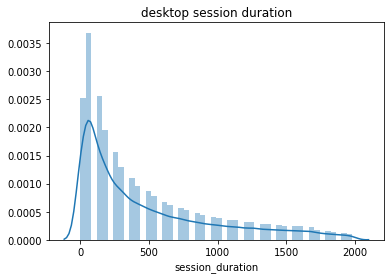

Text(0.5, 1.0, 'touch session duration')

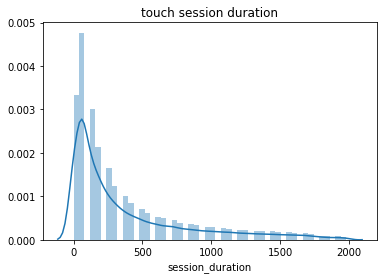

In [119]:
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits_durations = visits[visits['session_duration'] < 2000]
sns.distplot(visits_durations[visits_durations['device']=='desktop']['session_duration'])
plt.title('desktop session duration')
plt.show()
sns.distplot(visits_durations[visits_durations['device']=='touch']['session_duration'])
plt.title('touch session duration')

In [120]:
print('Средняя продолжительность сессии {} секунд'.format(int(visits['session_duration'].mode())))

Средняя продолжительность сессии 60 секунд


Отметим одинаковое распределение длины сессии для desktop и для touch

#### Рассчитаем Retention Rate

In [121]:
def retention(visits, device):
    visits=visits[visits['device']==device]
    first_visit = visits.groupby('uid')['start_ts'].min() 
    first_visit.name = 'first_visit'
    visits = visits.join(first_visit, on='uid')

    visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
    visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')

    visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
    visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
    visits['cohort_lifetime'] = visits['cohort_lifetime'].apply(np.round).astype('int') 

    cohorts = visits.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index() 

    initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]

    initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

    cohorts = cohorts.merge(initial_users_count,on='first_visit_month') 
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
    cohorts = cohorts[cohorts['cohort_lifetime'] > 0]
    retention_pivot = cohorts.pivot_table(index='first_visit_month',
                                          columns='cohort_lifetime',values='retention',aggfunc='sum')
    retention_pivot.index = retention_pivot.index.strftime('%Y-%m-%d')
    return retention_pivot

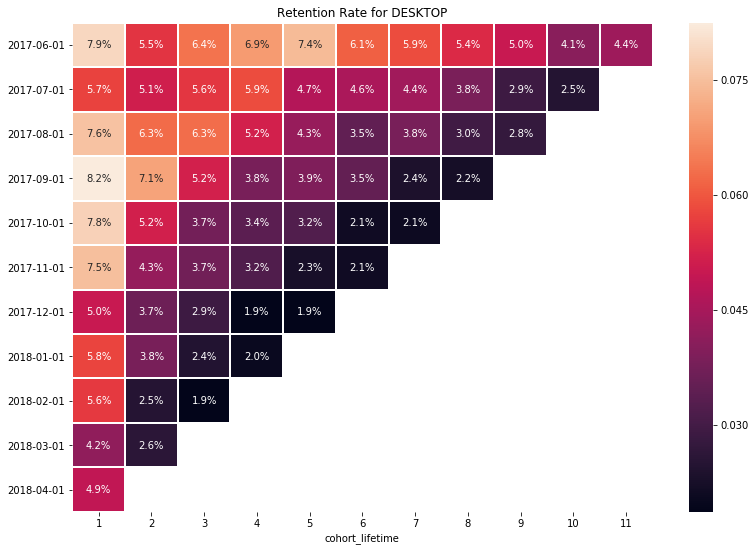

In [122]:
plt.figure(figsize=(13, 9))
plt.title('Retention Rate for DESKTOP')
sns.heatmap(retention(visits, 'desktop'), annot=True, fmt='.1%', linewidths=1, linecolor='white')
plt.show()

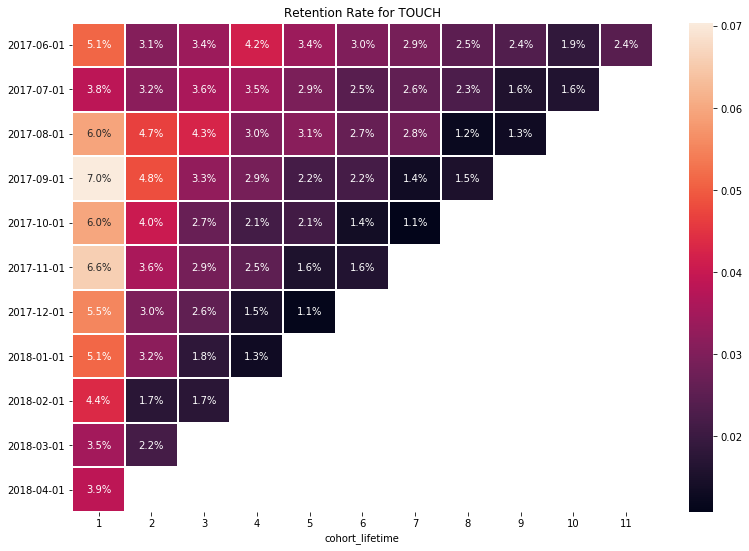

In [123]:
plt.figure(figsize=(13, 9))
plt.title('Retention Rate for TOUCH')
sns.heatmap(retention(visits, 'touch'), annot=True, fmt='.1%', linewidths=1, linecolor='white')
plt.show()

Отметим первую когорту 2017-06-01 как самую актинвую как для desktop, так и для touch. Для когорты 2017-12-01 дела не хороши, на 5 неделе существования лишь 1.9 процента остались пользователями платформы на desktop и 1.1 процент на touch.

Сравнивая когорты в целом, то видим, что на desktop остаётся больше людей чем на touch

In [124]:
first_visit = visits.groupby('uid')['start_ts'].min() 
first_visit.name = 'first_visit'
visits = visits.join(first_visit, on='uid')

visits['visit_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')

visits['cohort_lifetime'] = visits['visit_month'] - visits['first_visit_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].apply(np.round).astype('int')

<div id='id-section4'/>

### Метрики электронной коммерции

### Определим, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки

In [125]:
orders = orders.merge(visits.sort_values('start_ts').groupby('uid').first().reset_index(), on='uid', how='inner')

In [126]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 16 columns):
buy_ts               50415 non-null datetime64[ns]
revenue              50415 non-null float64
uid                  50415 non-null uint64
device               50415 non-null object
end_ts               50415 non-null datetime64[ns]
source_id            50415 non-null int64
start_ts             50415 non-null datetime64[ns]
session_year         50415 non-null int64
session_month        50415 non-null int64
session_week         50415 non-null int64
session_date         50415 non-null object
session_duration     50415 non-null int64
first_visit          50415 non-null datetime64[ns]
visit_month          50415 non-null datetime64[ns]
first_visit_month    50415 non-null datetime64[ns]
cohort_lifetime      50415 non-null int64
dtypes: datetime64[ns](6), float64(1), int64(6), object(2), uint64(1)
memory usage: 6.5+ MB


In [127]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
first_order = orders[orders['device']=='desktop'].groupby('uid')['buy_ts'].min()
first_order.name = 'first_order'
visits_orders_join = orders.join(first_order, on='uid')
visits_orders_join['first_order_duration'] = (visits_orders_join['first_order'] - visits_orders_join['first_visit'])/np.timedelta64(1, 'h')

print('DESKTOP Среднее время между первым посещением и первой покупкой : {:.2} часа'.format(visits_orders_join['first_order_duration'].median()))

DESKTOP Среднее время между первым посещением и первой покупкой : 0.33 часа


In [128]:
first_order.head()

uid
313578113262317    2018-01-03 21:51:00
2429014661409475   2017-10-11 18:33:00
2464366381792757   2018-01-28 15:54:00
2551852515556206   2017-11-24 10:14:00
3605148382144603   2017-09-21 20:56:00
Name: first_order, dtype: datetime64[ns]

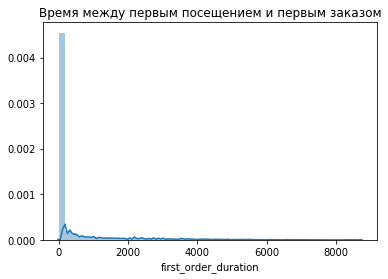

In [129]:
sns.distplot(visits_orders_join['first_order_duration'].dropna())
plt.title('Время между первым посещением и первым заказом')
plt.show()

In [130]:
first_order = orders[orders['device']=='touch'].groupby('uid')['buy_ts'].min()
first_order.name = 'first_order'
visits_orders_join = orders.join(first_order, on='uid')
visits_orders_join['first_order_duration'] = (visits_orders_join['first_order'] - visits_orders_join['first_visit'])/np.timedelta64(1, 'h')

print('TOUCH Среднее время между первым посещением и первой покупкой : {:.2} часа'.format(visits_orders_join['first_order_duration'].median()))

TOUCH Среднее время между первым посещением и первой покупкой : 0.95 часа


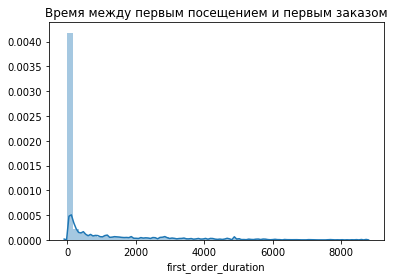

In [131]:
sns.distplot(visits_orders_join['first_order_duration'].dropna())
plt.title('Время между первым посещением и первым заказом')
plt.show()

### Применяя когортный анализ, рассчитайте среднее количество покупок на одного клиента за определённый период, например за 6 месяцев

In [132]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_orders = orders[orders['device']=='touch'].groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

orders_first_month = pd.merge(orders[orders['device']=='touch'],first_orders, on='uid')
cohorts = orders_first_month.groupby(['first_order_month','order_month']).agg({'revenue': ['sum', 'count']}).reset_index()
cohorts.columns = ['first_order_month', 'order_month', 'orders_sum', 'n_orders']
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['res'] = report['n_orders'] / report['n_buyers']

result = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='res', 
    aggfunc='mean')

result_touch = result.cumsum(axis=1).copy()
result_touch

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.121495,1.155763,1.171340,1.186916,1.230530,1.246106,1.264798,1.267913,1.280374,1.308411,1.320872,1.342679
2017-07-01,1.166247,1.206549,1.231738,1.289673,1.335013,1.360202,1.385390,1.415617,1.448363,1.463476,1.491184,NaN
2017-08-01,1.140625,1.179688,1.242188,1.265625,1.285156,1.320312,1.351562,1.386719,1.394531,1.421875,NaN,NaN
2017-09-01,1.151341,1.273946,1.354406,1.408046,1.423372,1.457854,1.486590,1.500000,1.515326,NaN,NaN,NaN
2017-10-01,1.160891,1.245050,1.284653,1.305693,1.325495,1.340347,1.351485,1.370050,NaN,NaN,NaN,NaN
2017-11-01,1.215894,1.298013,1.332450,1.366887,1.389404,1.398675,1.414570,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.176072,1.221219,1.237020,1.257336,1.266366,1.278781,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.125894,1.165951,1.180258,1.193133,1.204578,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.149289,1.196682,1.210900,1.218009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
first_orders = orders[orders['device']=='desktop'].groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

orders_first_month = pd.merge(orders,first_orders, on='uid')
cohorts = orders_first_month.groupby(['first_order_month','order_month']).agg({'revenue': ['sum', 'count']}).reset_index()
cohorts.columns = ['first_order_month', 'order_month', 'orders_sum', 'n_orders']
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['res'] = report['n_orders'] / report['n_buyers']
#report=report[report['age']>=6]
result = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='res', 
    aggfunc='mean')

result_desktop = result.cumsum(axis=1).copy()
result_desktop

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.171563,1.269095,1.368390,1.498237,1.661575,1.786722,1.945358,2.047004,2.169213,2.253819,2.307873,2.354289
2017-07-01,1.129096,1.184142,1.256225,1.309305,1.344692,1.391874,1.425295,1.450197,1.479685,1.491481,1.519004,NaN
2017-08-01,1.114004,1.201975,1.277379,1.344704,1.416517,1.464093,1.500898,1.562837,1.602334,1.637343,NaN,NaN
2017-09-01,1.132589,1.207868,1.265663,1.331714,1.360369,1.404565,1.449733,1.473531,1.499271,NaN,NaN,NaN
2017-10-01,1.139864,1.209513,1.246319,1.276048,1.308041,1.333805,1.355606,1.386750,NaN,NaN,NaN,NaN
2017-11-01,1.171076,1.271798,1.318701,1.374324,1.410102,1.425737,1.452796,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.146697,1.212468,1.266228,1.312268,1.334572,1.361453,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.120419,1.193717,1.249439,1.270007,1.296185,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.113288,1.178126,1.203420,1.226220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [134]:
print('TOUCH Среднее количество покупок на пользователя за 6 месяцев : {}'.format(result_touch[5].mean()))
print('DESKTOP Среднее количество покупок на пользователя за 6 месяцев : {}'.format(result_desktop[5].mean()))

TOUCH Среднее количество покупок на пользователя за 6 месяцев : 1.3431824865979027
DESKTOP Среднее количество покупок на пользователя за 6 месяцев : 1.4526069812885467



В среднем пользователи desktop покупают чаще чем touch

### Определим среднюю выручку на пользователея и покажем как она меняется со временем

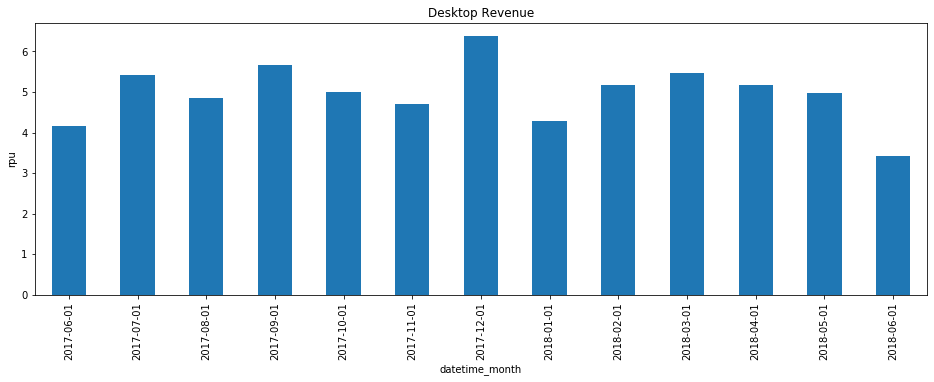

In [135]:
revenue = orders[orders['device']=='desktop'].groupby('order_month').agg({'revenue':'sum', 'uid':'count'})
revenue['revenue_per_user'] = revenue['revenue'] / revenue['uid']
revenue.index = revenue.index.strftime('%Y-%m-%d')
ax=revenue['revenue_per_user'].plot(kind='bar', figsize=(16, 5), title='Desktop Revenue')
ax.set_xlabel('datetime_month')
ax.set_ylabel('rpu')
plt.show()

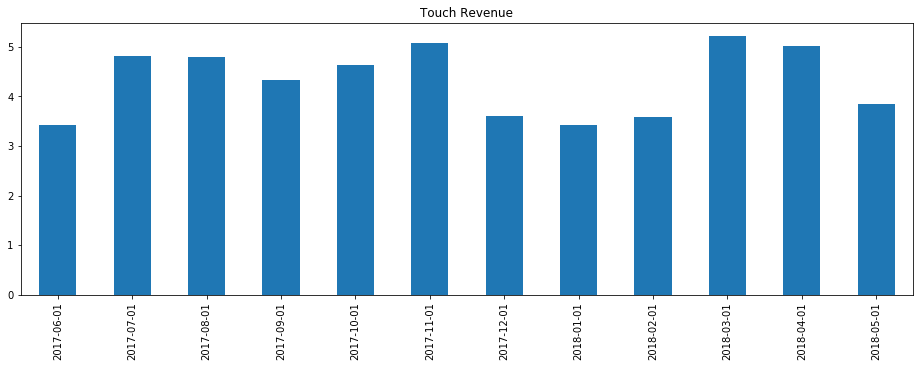

In [136]:
revenue_touch = orders[orders['device']=='touch'].groupby('order_month').agg({'revenue':'sum', 'uid':'count'})
revenue_touch['revenue_per_user'] = revenue_touch['revenue'] / revenue_touch['uid']
revenue_touch.index = revenue_touch.index.strftime('%Y-%m-%d')
revenue_touch['revenue_per_user'].plot(kind='bar', figsize=(16, 5), title='Touch Revenue')
ax.set_xlabel('datetime_month')
ax.set_ylabel('rpu')
plt.show()

In [137]:
print('DESKTOP Средняя выручка с пользователя за весь период : {}'.format(revenue['revenue_per_user'].mean()))
print('TOUCH Средняя выручка с пользователя за весь период : {}'.format(revenue_touch['revenue_per_user'].mean()))

DESKTOP Средняя выручка с пользователя за весь период : 4.976402325225101
TOUCH Средняя выручка с пользователя за весь период : 4.318152067501028


Пересчитал по хитам, теперь все совпадает

In [138]:
orders_start_df['Revenue'].describe().T

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: Revenue, dtype: float64

Средняя выручка на пользователя на платформе desktop выше. Отметим резкое увеличение выручки в декабре 2017 для desktop.

### Определим как меняется во времени накопительный LTV по когортам. Сравните средний LTV по когортам за 6 месяцев. Оценивайте когорты, «прожившие» не менее 6 месяцев.

In [139]:
orders.head()

,buy_ts,revenue,uid,device,end_ts,source_id,start_ts,session_year,session_month,session_week,session_date,session_duration,first_visit,visit_month,first_visit_month,cohort_lifetime,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,2017,6,22,2017-06-01,120,2017-06-01 00:09:00,2017-06-01,2017-06-01,0,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,660,2017-06-01 00:14:00,2017-06-01,2017-06-01,0,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,2017,6,22,2017-06-01,540,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,1140,2017-06-01 00:14:00,2017-06-01,2017-06-01,0,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,2017,6,22,2017-06-01,1680,2017-06-01 07:31:00,2017-06-01,2017-06-01,0,2017-06-01


In [140]:
first_orders = orders[orders['device']=='touch'].groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

orders_first_month = pd.merge(orders[orders['device']=='touch'],first_orders, on='uid')
cohorts = orders_first_month.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['ltv'] = report['revenue'] / report['n_buyers']

result = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean')
result_touch = result.cumsum(axis=1).copy()
result_touch.index = result_touch.index.strftime('%Y-%m-%d')
result_touch

age,0,1,2,3,4,5,6,7,8,9,10,11
2017-06-01,3.850841,4.160467,4.287072,4.368723,4.604579,4.645483,4.686137,4.708972,4.756480,4.912212,4.976885,5.239595
2017-07-01,5.512065,5.726902,5.784156,6.277960,6.452343,6.592040,6.649597,6.777733,6.851662,6.947859,7.071184,NaN
2017-08-01,5.368203,5.499961,5.691094,5.835586,5.901250,6.153008,6.288125,6.403281,6.460078,6.551836,NaN,NaN
2017-09-01,5.041130,6.911916,7.854655,8.362318,8.439962,8.625134,10.021839,10.293142,10.340211,NaN,NaN,NaN
2017-10-01,4.450149,4.879988,4.998007,5.054220,5.185990,5.217748,5.241386,5.300854,NaN,NaN,NaN,NaN
2017-11-01,5.851457,6.038344,6.101391,6.188093,6.272583,6.299960,6.328053,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.171501,4.343804,4.414458,4.473555,4.487336,4.517788,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.851087,3.959914,4.042546,4.110572,4.139871,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.052062,4.206706,4.242773,4.263993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,5.782460,6.502672,6.793915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:
first_orders = orders[orders['device']=='desktop'].groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

orders_first_month = pd.merge(orders[orders['device']=='desktop'],first_orders, on='uid')
cohorts = orders_first_month.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

report['ltv'] = report['revenue'] / report['n_buyers']
result = report.pivot_table(
    index='first_order_month', 
    columns='age', 
    values='ltv', 
    aggfunc='mean')
result_desktop = result.cumsum(axis=1).copy()
result_desktop.index = result_desktop.index.strftime('%Y-%m-%d')
result_desktop

age,0,1,2,3,4,5,6,7,8,9,10,11
2017-06-01,4.889172,5.407638,5.903937,7.023261,8.194160,9.060664,10.182691,10.869665,11.518255,12.208925,12.875729,13.131481
2017-07-01,6.139817,6.506343,7.277195,7.601094,7.778512,7.938814,8.075321,8.220701,8.404646,8.565046,8.729135,NaN
2017-08-01,5.255449,5.805628,6.325548,6.773537,7.366032,7.656876,7.884901,8.356517,8.702828,8.912917,NaN,NaN
2017-09-01,5.797504,6.724138,7.138130,11.993167,12.475590,13.239757,13.765143,14.001156,14.219879,NaN,NaN,NaN
2017-10-01,5.130374,5.690368,5.898548,6.078783,6.234870,6.375501,6.474312,6.602593,NaN,NaN,NaN,NaN
2017-11-01,4.996515,5.443951,5.674495,6.053530,6.215962,6.275857,6.410496,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.881767,5.164455,6.306034,7.626234,8.014956,8.430935,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.210019,4.553381,4.915602,5.077921,5.149349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.188536,4.503983,4.595262,4.685319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01,4.581905,4.768642,5.090821,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [142]:
print('TOUCH Средний LTV за 6 месяцев : {}'.format(result_touch[6].mean()))
print('DESKTOP Средний LTV за 6 месяцев : {}'.format(result_desktop[6].mean()))

TOUCH Средний LTV за 6 месяцев : 6.535856208031195
DESKTOP Средний LTV за 6 месяцев : 8.798810779806006


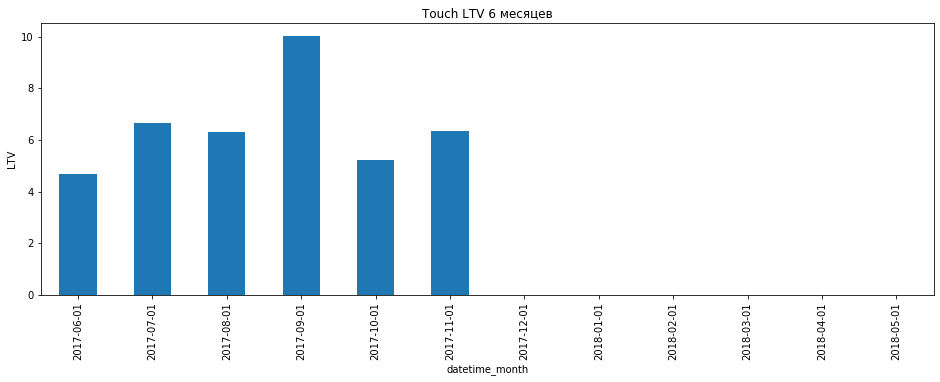

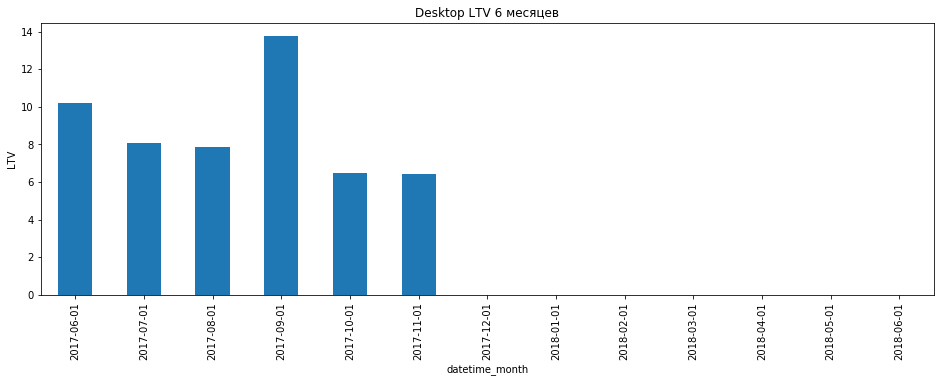

In [143]:
ax=result_touch[6].plot(kind='bar', figsize=(16, 5), title='Touch LTV 6 месяцев')
ax.set_xlabel('datetime_month')
ax.set_ylabel('LTV')
plt.show()

ax=result_desktop[6].plot(kind='bar', figsize=(16, 5), title='Desktop LTV 6 месяцев')
ax.set_xlabel('datetime_month')
ax.set_ylabel('LTV')
plt.show()

Наибольшие показатели LTV за 6 месяцев у когорты 2017-09-01 для обеих платформ. Наименьший LTV для когорты 2017-10-01 и 2017-11-01 для desktop, у когорты 2017-06-01 для платформы touch

<div id='id-section5'/>

### Определим общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам и как меняется это распределение во времени

In [144]:
print('Общая сумма расходов : {}'.format(costs['costs'].sum()))

Общая сумма расходов : 329131.62


In [145]:
costs['dt'] = pd.to_datetime(costs['dt'])
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


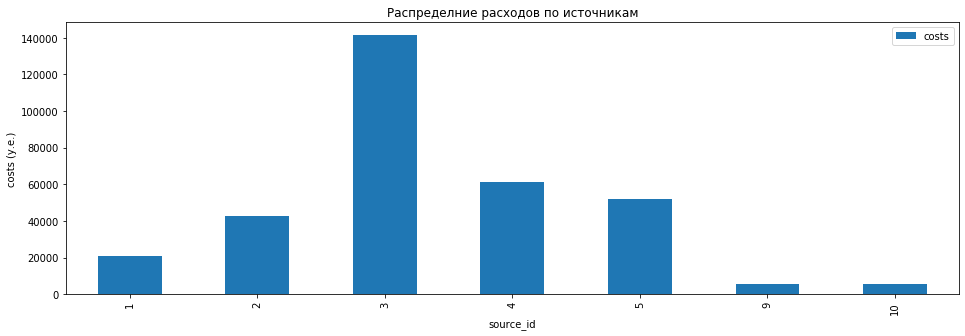

In [146]:
ax = costs.groupby(['source_id']).agg({'costs':'sum'}).plot(kind='bar', title='sources', figsize=(16, 5))
plt.title('Распределние расходов по источникам')
ax.set_xlabel('source_id')
ax.set_ylabel('costs (у.е.)')
plt.show()

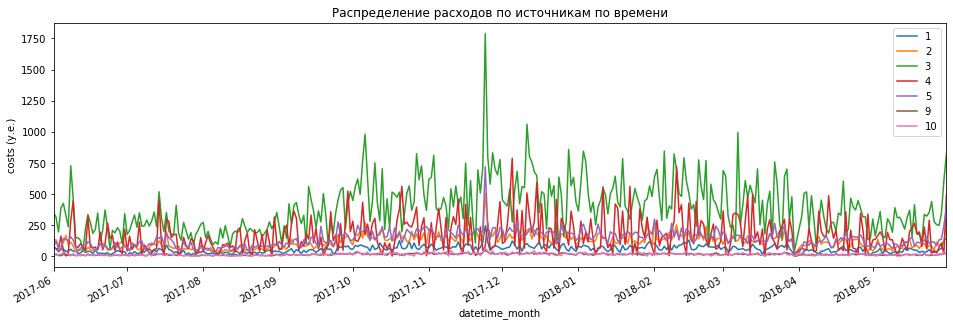

In [147]:
data = costs.groupby(['source_id', 'dt']).agg({'costs':'sum'})
list = [2, 3, 4, 5, 9, 10]
bx = data.loc[1].plot(kind='line', figsize=(16, 5), label='1')
for i in list:
    ax = data.loc[i].plot(kind='line', figsize=(16, 5), label='i', ax=bx, title='')
    bx = ax
bx.legend([1, 2, 3, 4, 5, 9, 10])
plt.title('Распределение расходов по источникам по времени')
ax.set_xlabel('datetime_month')
ax.set_ylabel('costs (у.е.)')
plt.show()

По графикам видно, что основные траты идут на источники 3 и 4. В основном преобладает источник 3.

### Определим CAC. Определите, сколько стоит привлечение одного покупателя из каждого источника трафика

In [148]:
costs_group = costs.groupby(['dt', 'source_id']).agg({'costs':'sum'}).reset_index()

In [149]:
buyers = visits.groupby('uid')[['start_ts','source_id']].first().reset_index()
buyers_group = buyers.groupby('source_id').agg({'uid':'nunique'})
buyers_group

,uid
source_id,
1,11746
2,19389
3,62674
4,71905
5,48884
6,3
7,33
9,6770
10,6765


In [150]:
buyers = buyers[['uid', 'source_id']]
buyers.columns = ['uid', 'first_source_id']
orders = pd.merge(orders, buyers, on='uid')
orders

,buy_ts,revenue,uid,device,end_ts,source_id,start_ts,session_year,session_month,session_week,session_date,session_duration,first_visit,visit_month,first_visit_month,cohort_lifetime,order_month,first_source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,2017,6,22,2017-06-01,120,2017-06-01 00:09:00,2017-06-01,2017-06-01,0,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,660,2017-06-01 00:14:00,2017-06-01,2017-06-01,0,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,2017,6,22,2017-06-01,540,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,1140,2017-06-01 00:14:00,2017-06-01,2017-06-01,0,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,2017,6,22,2017-06-01,1680,2017-06-01 07:31:00,2017-06-01,2017-06-01,0,2017-06-01,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,touch,2018-05-31 09:12:00,4,2018-05-31 09:11:00,2018,5,22,2018-05-31,60,2018-05-31 09:11:00,2018-05-01,2018-05-01,0,2018-05-01,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,desktop,2018-05-31 23:55:00,10,2018-05-31 23:05:00,2018,5,22,2018-05-31,3000,2018-05-31 23:05:00,2018-05-01,2018-05-01,0,2018-05-01,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,desktop,2018-05-31 23:55:00,3,2018-05-31 23:52:00,2018,5,22,2018-05-31,180,2018-05-31 23:52:00,2018-05-01,2018-05-01,0,2018-05-01,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,desktop,2017-10-23 12:36:00,3,2017-10-23 12:32:00,2017,10,43,2017-10-23,240,2017-10-23 12:32:00,2017-10-01,2017-10-01,0,2018-05-01,4


In [151]:
# определяем источник пользователя
sources = visits.sort_values(by = ['uid', 'start_ts']).groupby('uid').agg({'source_id': 'first'})
sources.head(1)

,source_id
uid,
11863502262781,3


In [152]:
payers = orders.groupby('uid').agg({'buy_ts': 'min'}).merge(sources, on = 'uid').reset_index()
payers = payers.rename(columns = {'buy_ts': 'first_buy'})
payers.head(1)

,uid,first_buy,source_id
0,313578113262317,2018-01-03 21:51:00,2


In [153]:
# добавляем размеры "когорт"
cohort_sizes = payers.groupby('source_id').agg({'uid': 'nunique'}).rename(columns = {'uid': 'cohort_size'})
cohort_sizes.head(1)

,cohort_size
source_id,
1,2899


In [154]:
# считаем САС
cac = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index().merge(cohort_sizes.reset_index(), left_on = 'source_id', right_on='source_id')
cac['CAC'] = cac_1['costs'] / cac['cohort_size']
display(cac)

,source_id,costs,cohort_size,CAC
0,1,20833.27,2899,7.186364
1,2,42806.04,3506,12.209367
2,3,141321.63,10473,13.493901
3,4,61073.60,10296,5.931779
4,5,51757.10,6931,7.467479
5,9,5517.49,1088,5.071222
6,10,5822.49,1329,4.381106


### Вычислим ROMI по когортам в разрезе источников. Сравните окупаемость за одинаковые периоды жизни когорт

In [155]:
orders

,buy_ts,revenue,uid,device,end_ts,source_id,start_ts,session_year,session_month,session_week,session_date,session_duration,first_visit,visit_month,first_visit_month,cohort_lifetime,order_month,first_source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,desktop,2017-06-01 00:11:00,1,2017-06-01 00:09:00,2017,6,22,2017-06-01,120,2017-06-01 00:09:00,2017-06-01,2017-06-01,0,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,desktop,2017-06-01 00:25:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,660,2017-06-01 00:14:00,2017-06-01,2017-06-01,0,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,desktop,2017-06-01 00:34:00,2,2017-06-01 00:25:00,2017,6,22,2017-06-01,540,2017-06-01 00:25:00,2017-06-01,2017-06-01,0,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,desktop,2017-06-01 00:33:00,2,2017-06-01 00:14:00,2017,6,22,2017-06-01,1140,2017-06-01 00:14:00,2017-06-01,2017-06-01,0,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,desktop,2017-06-01 07:59:00,3,2017-06-01 07:31:00,2017,6,22,2017-06-01,1680,2017-06-01 07:31:00,2017-06-01,2017-06-01,0,2017-06-01,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,touch,2018-05-31 09:12:00,4,2018-05-31 09:11:00,2018,5,22,2018-05-31,60,2018-05-31 09:11:00,2018-05-01,2018-05-01,0,2018-05-01,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,desktop,2018-05-31 23:55:00,10,2018-05-31 23:05:00,2018,5,22,2018-05-31,3000,2018-05-31 23:05:00,2018-05-01,2018-05-01,0,2018-05-01,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,desktop,2018-05-31 23:55:00,3,2018-05-31 23:52:00,2018,5,22,2018-05-31,180,2018-05-31 23:52:00,2018-05-01,2018-05-01,0,2018-05-01,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,desktop,2017-10-23 12:36:00,3,2017-10-23 12:32:00,2017,10,43,2017-10-23,240,2017-10-23 12:32:00,2017-10-01,2017-10-01,0,2018-05-01,4


In [156]:
def for_romi(orders):
    first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
    first_orders.columns = ['uid', 'first_order_month']

    cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'n_buyers']

    orders_first_month = pd.merge(orders, first_orders, on='uid')
    cohorts = orders_first_month.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

    report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')

    report['ltv'] = report['revenue'] / report['n_buyers']
    result = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
    result = result.cumsum(axis=1).copy()
    result.index = result.index.strftime('%Y-%m-%d')
    return result[5].mean()

In [157]:
list=[1, 2, 3, 4, 5, 9, 10]
ltv_touch = pd.DataFrame(columns=['source_id', 'LTV'])
for i in list:
    ltv_touch = ltv_touch.append({'source_id':i, 'LTV':for_romi(orders[(orders['first_source_id']==i)&(orders['device']=='touch')])}, ignore_index=True)

ltv_touch['source_id'] = ltv_touch['source_id'].astype('int64')
romi_touch = ltv_touch.merge(cac, on='source_id')
romi_touch['ROMI'] = romi_touch['LTV'] / romi_touch['CAC']
romi_touch[['LTV', 'CAC', 'ROMI']]

,LTV,CAC,ROMI
0,8.383207,7.186364,1.166544
1,8.341768,12.209367,0.683227
2,4.501092,13.493901,0.333565
3,5.752244,5.931779,0.969733
4,4.954557,7.467479,0.663485
5,6.482197,5.071222,1.278232
6,6.080000,4.381106,1.387777


In [158]:
list=[1, 2, 3, 4, 5, 9, 10]
ltv_desktop = pd.DataFrame(columns=['source_id', 'LTV'])
for i in list:
    ltv_desktop = ltv_desktop.append({'source_id':i, 'LTV':for_romi(orders[(orders['first_source_id']==i)&(orders['device']=='desktop')])}, ignore_index=True)

ltv_desktop['source_id'] = ltv_desktop['source_id'].astype('int64')
romi_desktop = ltv_desktop.merge(cac, on='source_id')
romi_desktop['ROMI'] = romi_desktop['LTV'] / romi_desktop['CAC']
romi_desktop[['LTV', 'CAC', 'ROMI']]

,LTV,CAC,ROMI
0,11.124247,7.186364,1.547966
1,22.928701,12.209367,1.877960
2,5.459087,13.493901,0.404560
3,5.845045,5.931779,0.985378
4,6.919052,7.467479,0.926558
5,5.748857,5.071222,1.133624
6,3.447453,4.381106,0.786891


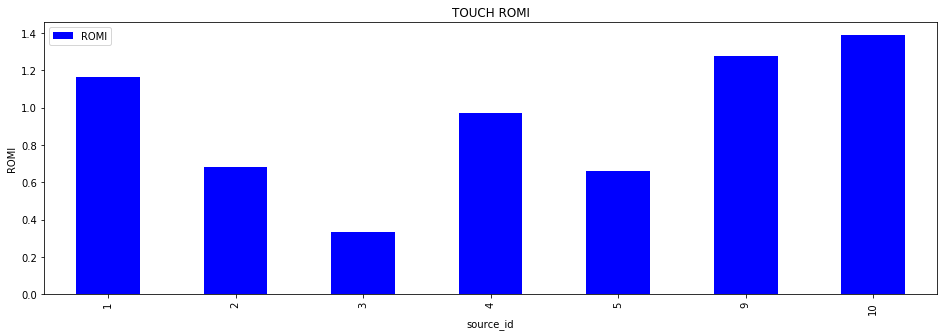

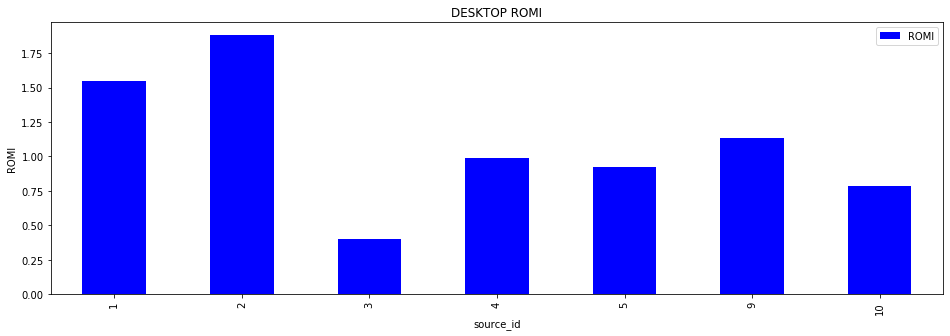

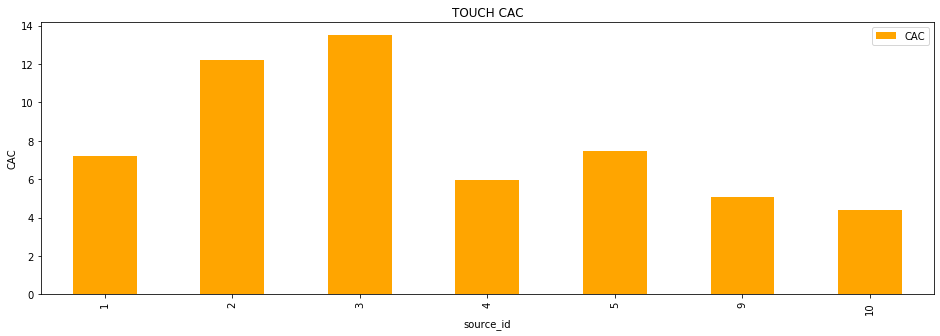

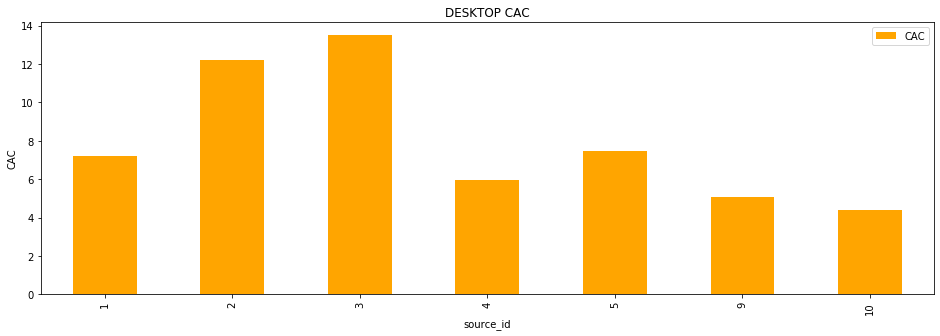

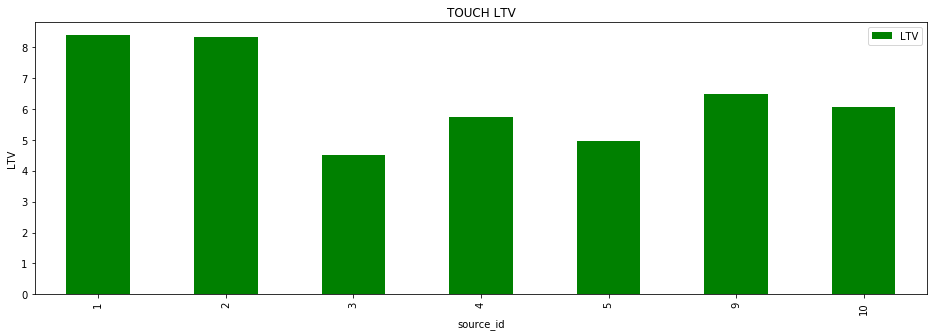

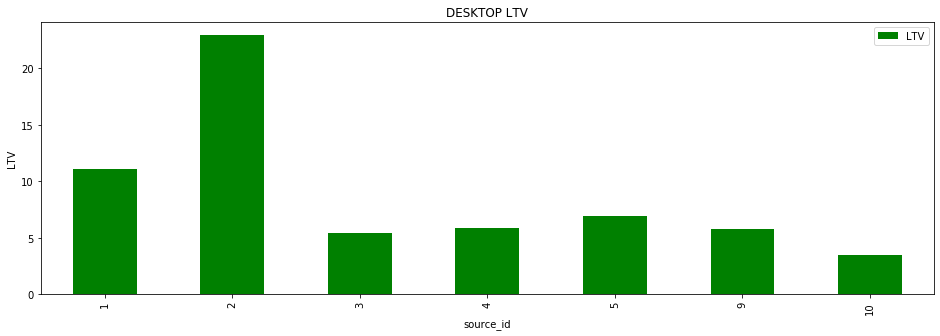

In [159]:
ax=romi_touch.plot(kind='bar', y='ROMI', x='source_id', title='TOUCH ROMI', figsize=(16, 5), color='blue')
ax.set_ylabel('ROMI')
plt.show()
ax=romi_desktop.plot(kind='bar', y='ROMI', x='source_id', title='DESKTOP ROMI', figsize=(16, 5), color='blue')
ax.set_ylabel('ROMI')
plt.show()
ax=romi_touch.plot(kind='bar', y='CAC', x='source_id', title='TOUCH CAC', figsize=(16, 5), color='orange')
ax.set_ylabel('CAC')
plt.show()
ax=romi_desktop.plot(kind='bar', y='CAC', x='source_id', title='DESKTOP CAC', figsize=(16, 5), color='orange')
ax.set_ylabel('CAC')
plt.show()
ax=romi_touch.plot(kind='bar', y='LTV', x='source_id', title='TOUCH LTV', figsize=(16, 5), color='green')
ax.set_ylabel('LTV')
plt.show()
ax=romi_desktop.plot(kind='bar', y='LTV', x='source_id', title='DESKTOP LTV', figsize=(16, 5), color='green')
ax.set_ylabel('LTV')
plt.show()

Для платформы touch лидером по ROMI является источник 4. Для desktop - источники 1, 4 и 5. Отметим высокий показатель CAC и низкий ROMI по 3 источнику для обеих платформ.

<div id='id-section6'/>

## Выводы и рекомендации

### Определите источники трафика и тип устройств, на которые маркетологам стоит делать упор. Объясните свой выбор: на какие метрики вы ориентируетесь и почему

Основываясь на ROMI можем сделать вывод, что для платформе touch 10, 9 и 1 источники являются лидерами. Касательно Desktop видно, что 3 источник является самым затратным, а 1 и 2 лидируют. Можем сделать вывод, что стоит сократить бюджет на 3 источник

### Опишите выводы, которые вы сделали после подсчёта метрик каждого вида: маркетинговых, продуктовых и метрик электронной коммерции

Отметим, что на конец 2017 года пришлось наибольшее среднее количество посещений для пользователя в день. Однако во втором квартале 2018 года график находится в том же среднем диапозоне, в то время как метрики DAU, WAU, MAU падают. То есть, теряя активную аудиторию, пользователи использующие платформу заходят также.

Отметим резкое подаение посещаемости во втором квартале 2018 году. Снижаются такие метрики как DAU, WAU и MAU. В целом пользователей с desktop больше чем с touch, однаком поведение графиков схоже.

---

Отметим одинаковое распределение длины сессии для desktop и для touch. В среднем 60 секунд

---

DESKTOP Среднее время между первым посещением и первой покупкой : 0.33 часа

TOUCH Среднее время между первым посещением и первой покупкой : 0.95 часа

---

TOUCH Среднее количество покупок на пользователя за 6 месяцев : 1.3

DESKTOP Среднее количество покупок на пользователя за 6 месяцев : 1.4

Пользователи desktop покупают чаще чем touch

---

DESKTOP Средняя выручка с пользователя за весь период : 4.9

TOUCH Средняя выручка с пользователя за весь период : 4.3

Средняя выручка на пользователя на платформе desktop выше. Отметим резкое увеличение выручки в декабре 2017 для desktop

---

TOUCH Средний LTV за 6 месяцев : 6.5

DESKTOP Средний LTV за 6 месяцев : 8.7

Наибольшие показатели LTV за 6 месяцев у когорт 2017-06-01 и 2017-09-01. Наименьший LTV для когорты 2017-07-01 для desktop.

В случае с touch отметим выделяющуюся когорту 2017-09-01

---

Общая сумма маркетинговых расходов составляет 329131.62 у.е.

Видим, что при высоких тратах на источник 3, CAC для него остается наиболее высоким во всем периоде. Вероятно, стоит уменьшить бюджет на этот источник.




### Подведите итоги когортного анализа. Определите самые перспективные для компании когорты клиентов

Отметим первую когорту 2017-06-01 как самую актинвую как для desktop, так и для touch. Для когорты 2017-12-01 дела не хороши, на 5 месяце существования лишь 1.9 процента остались пользователями платформы на desktop и 1.1 процент на touch.

Сравнивая когорты в целом, то видим, что на desktop остаётся больше людей чем на touch.

Наибольшие показатели LTV за 6 месяцев у когорты 2017-09-01 для обеих платформ. Наименьший LTV для когорты 2017-10-01 и 2017-q1-01 для desktop, у когорты 2017-06-01 для платформы touch.

Отметим большую разницу ltv между когортами в случае touch

### Опишите, как различаются метрики в разрезе устройств

Видим, что в разрезе устройств пользователи touch устройств имеют меньшее количество покупок на пользователя. Время до первого заказа для touch также выше. В целом привлечение пользователей устройств touch обходится дороже, retention rate для них также ниже.